In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

# Define paths to the images folder and CSV file
img_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"



In [1]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 5.3 MB/s eta 0:00:00


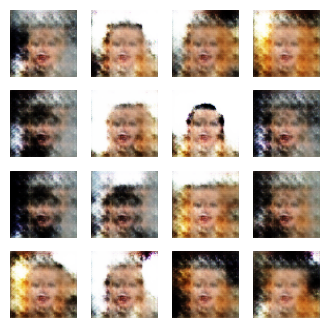

Time for epoch 21 is 611.7489356994629 sec


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import glob
import imageio
from IPython import display

# ---------------------------------------------------------
# 1. Load and Prepare the CelebA Dataset
# ---------------------------------------------------------
# Path to the folder containing the CelebA images (JPG files)
IMG_DIR = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
IMG_SIZE = 64       # We will resize images to 64x64
BATCH_SIZE = 256
BUFFER_SIZE = 60000

def load_and_preprocess_image(image_path):
    # Read the image from disk
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG (3 channels for color)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to IMG_SIZE x IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize the pixel values to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

# Create a tf.data.Dataset from the image files
dataset = tf.data.Dataset.list_files(os.path.join(IMG_DIR, "*.jpg"))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ---------------------------------------------------------
# 2. Build the Generator Model
# ---------------------------------------------------------
def make_generator_model():
    model = tf.keras.Sequential()
    # Start with a dense layer that creates a 4x4x1024 tensor from a 100-dim noise vector
    model.add(layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)  # (batch_size, 4, 4, 1024)

    # Upsample to 8x8x512
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, 8, 8, 512)

    # Upsample to 16x16x256
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, 16, 16, 256)

    # Upsample to 32x32x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, 32, 32, 128)

    # Upsample to 64x64x3 (output image with 3 channels and tanh activation)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)
    
    return model

generator = make_generator_model()

# ---------------------------------------------------------
# 3. Build the Discriminator Model
# ---------------------------------------------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Downsample: 64x64x3 -> 32x32x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Downsample: 32x32x64 -> 16x16x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Downsample: 16x16x128 -> 8x8x256
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    # Output single scalar per image. (No activation here because we use logits.)
    model.add(layers.Dense(1))
    
    return model

discriminator = make_discriminator_model()

# ---------------------------------------------------------
# 4. Define Loss Functions and Optimizers
# ---------------------------------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # Loss on real images (should be 1) and on fake images (should be 0)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Generator wants discriminator to believe the generated images are real (label=1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ---------------------------------------------------------
# 5. Checkpoint Setup (to save and restore models)
# ---------------------------------------------------------
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# ---------------------------------------------------------
# 6. Define the Training Loop
# ---------------------------------------------------------
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed to visualize progress during training.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # Generate and save images after each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Scale back to [0, 255] for display
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# ---------------------------------------------------------
# 7. Train the DCGAN on CelebA
# ---------------------------------------------------------
train(dataset, EPOCHS)

# Optionally, to restore the latest checkpoint later:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# ---------------------------------------------------------
# 8. Create an Animated GIF of the Generated Images
# ---------------------------------------------------------
anim_file = 'dcgan_celeba.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image again to hold at the end
    image = imageio.imread(filenames[-1])
    writer.append_data(image)



In [ ]:
!# Display the GIF (requires tensorflow_docs; otherwise, open the file manually)
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)